### Loading the data

Data  description -  the data contains solar flux data recorded from 1947 until 2020. 
the data has columns `Date` and solar flux reading in sfu or solar flux units with column name `sfu` 

In [30]:
import pandas as pd

# Define the file path
file_path = "data.txt"  # Replace with the actual file path

# Read the data from the text file into a DataFrame
df = pd.read_csv(file_path, sep=';', header=None, names=['Date', 'sfu'])

# Display the DataFrame
df

,Date,sfu
0,1947-02-14 00:00:00,260.0
1,1947-02-17 00:00:00,234.0
2,1947-02-19 00:00:00,183.0
3,1947-02-20 00:00:00,167.0
4,1947-02-24 00:00:00,167.0
...,...,...
44513,2020-12-30 20:00:00,82.8
44514,2020-12-30 22:00:00,83.2
44515,2020-12-31 18:00:00,81.9
44516,2020-12-31 20:00:00,81.2


In [34]:
df['Date'] = pd.to_datetime(df['Date'])

### Visualizing the data

we use smoothing function to effectively visualize the model. 

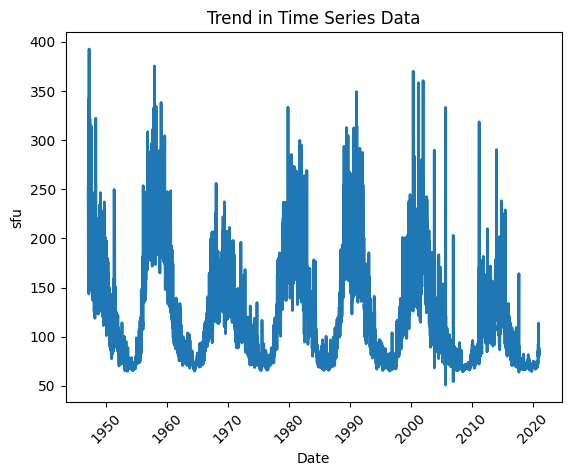

In [5]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by the 'Date' column
df.sort_values(by='Date', inplace=True)

# Smoothing the data using Savitzky-Golay filter
window_size = 11
poly_order = 2
smoothed_values = savgol_filter(df['sfu'], window_size, poly_order)

# Plot the smoothed curve
plt.plot(df['Date'], smoothed_values, linewidth=2)

# Set the plot title and labels
plt.title("Trend in Time Series Data")
plt.xlabel("Date")
plt.ylabel("sfu")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


### Data Preparation 

we notice that some of the dates in the data  are missing. to handle this we apply imputation to fill the data 

In [49]:
import pandas as pd

def check_missing_dates(df, date_column):
    # # Convert date_column to datetime if it is not already
    # if not pd.api.types.is_datetime64_any_dtype(df[date_column]):
    #     df[date_column] = pd.to_datetime(df[date_column])

    # Generate a complete date range based on the minimum and maximum dates in the DataFrame
    min_date = df[date_column].min().date()
    max_date = df[date_column].max().date()
    complete_date_range = pd.date_range(start=min_date, end=max_date, freq='D').date

    # Identify missing dates
    missing_dates = complete_date_range[~pd.Index(complete_date_range).isin(df[date_column].dt.date)]

    return missing_dates

# Example usage
missing_dates = check_missing_dates(modified_df, 'Date')
if len(missing_dates) > 0:
    print("Missing",len(missing_dates),  " dates found:")
    print(missing_dates)
else:
    print("No missing dates found.")


Missing 642  dates found:
[datetime.date(1947, 2, 15) datetime.date(1947, 2, 16)
 datetime.date(1947, 2, 18) datetime.date(1947, 2, 21)
 datetime.date(1947, 2, 22) datetime.date(1947, 2, 23)
 datetime.date(1947, 2, 27) datetime.date(1947, 3, 1)
 datetime.date(1947, 3, 2) datetime.date(1947, 3, 3)
 datetime.date(1947, 3, 4) datetime.date(1947, 3, 9)
 datetime.date(1947, 3, 16) datetime.date(1947, 3, 23)
 datetime.date(1947, 4, 6) datetime.date(1947, 4, 13)
 datetime.date(1947, 4, 15) datetime.date(1947, 4, 16)
 datetime.date(1947, 4, 20) datetime.date(1947, 4, 27)
 datetime.date(1947, 5, 4) datetime.date(1947, 5, 11)
 datetime.date(1947, 5, 18) datetime.date(1947, 5, 24)
 datetime.date(1947, 5, 25) datetime.date(1947, 6, 1)
 datetime.date(1947, 6, 8) datetime.date(1947, 6, 9)
 datetime.date(1947, 6, 15) datetime.date(1947, 6, 22)
 datetime.date(1947, 6, 29) datetime.date(1947, 7, 1)
 datetime.date(1947, 7, 6) datetime.date(1947, 7, 13)
 datetime.date(1947, 7, 20) datetime.date(1947, 7, 

In [12]:
# export
import numpy as np
import pandas as pd
from scipy.stats import boxcox, pearsonr
from scipy.special import inv_boxcox
from pandas.tseries.frequencies import to_offset
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import aic, bic
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [ ]:
# export
class cPreProcessing():
    """
    Parent class.
    
    Methods for dealing with irregularly spaced or missing data.
    """
    
    def __init__(self):
        pass
    
    def fget_regular_times(self, df, timestep):
        """
        Generate dataframe of regularly spaced times (to impute to)
        (From fbprophet/forecaster/make_future_dataframe)
        
        Parameters
        ----------
        df       = [pandas dataframe]
        timestep = [datetime timedelta object]
        
        
        Returns
        -------
        regtimes = [pandas DatetimeIndex] of datetimes regularly spaced at timestep
        
        """
        # normalize start date to midnight
        start_date = df.ds.min().normalize()

        # round up end date by one extra timestep
        end_date = (df.ds.max() + timestep).normalize()

        # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html
        regtimes = pd.date_range(start=start_date, end=end_date, freq=to_offset(timestep))

        return regtimes
    
    def finterleaf(self, df, impute_times):
        """
        Interleaf dataframe with new prediction times
        Set values at prediction dates as NaN so can use imputer

        Parameters
        ----------
        df           = [pandas dataframe]
        impute_times = [pandas DatetimeIndex] (format of regtimes)

        Returns
        -------
        dft = pandas dataframe (format for use in fimpute)
        """
        # if impute_times taken from fmake_regular_times()
        if type(impute_times) == pd.core.indexes.datetimes.DatetimeIndex:
            impute_times = pd.DataFrame(impute_times)
            impute_times.columns = ["ds"]

        # set date index
        df.set_index('ds', inplace=True)
        impute_times.set_index('ds', inplace=True)

        # combine (interleaf)
        dft = pd.concat([df, impute_times], sort=True)
        dft.sort_values(by=["ds"], inplace=True)
        
        # remove duplicate entries
        dft = dft[dft.index.duplicated() == False]

        return dft
    
    def fimpute(self, df, method="time"):
        """
        Imputation of data to new timestamps with NaN value.

        Parameters
        ----------
        df = dataframe containing original data and NaNs at timestamps for imputation
             timestamps are the df index
        
        Returns
        -------
        dfi = imputed dataframe
        """
        # interpolates halfway, doesn´t account for weighting towards closer time
        if method == "interp":
            dfi = df.interpolate()

        # missing values given mean value over whole time series
        if method == "mean":
            imp = SimpleImputer(missing_values=np.nan, strategy='mean')
            imp.fit(df)
            dfi = imp.transform(df)

        # linear interpolation weighted by timestamp proximity
        if method == "time":
            dfi = df.interpolate(method='time') 

        # smoothing
        if method == "akima":
            dfi = df.interpolate(method='akima')

        return dfi
    
    def fmake_regular_freq(self, df, timestep, method="time"):
        """
        Interpolate data so regular update frequency throughout dataset.
        (Deal with missing values)
        
        Some python functions (e.g. seasonal_decompose, AutoArima) require a data "freq" argument
        to determine seasonality. (Can be inferred from df.index.freq, df.index.inferred_freq)
        Such functions require a constant data frequency.
        
        Parameters
        ----------
        df       = irregularly space dataframe (with datestamp name "ds")
        timestep = desired update frequency of data (timedelta object)
        method   = imputation method
        
        Returns
        -------
        dff = imputed regularly spaced [pandas dataframe]
        """
        # 0. preprocess: if dataframe alreay has time as index: reset and add as column
        if df.index.name == "ds":
            # df_lim["ds"] = df_lim.index
            df.reset_index(level=0, inplace=True)
        
        # 1. include in dataset times where you want to impute (and set to NaN values)
        impute_times = self.fget_regular_times(df, timestep)
        dft = self.finterleaf(df, impute_times)
        
        # 2. impute with chosen method
        dfi = self.fimpute(dft, method=method)
        
        # 3. remove original data not at correct timestep
        dff = dfi[dfi.index.isin(impute_times) == True]
        
        if dff.index.freq == None:
            dff.index.freq = to_offset(timestep)
        
        return dff

out approch to handle missing data is to generate a list of dates in regular interwals

In [19]:
freq = 'D'                                                     # 'H' for hours, etc.
timestep =  pd.Timedelta(1, unit=freq) 

# normalize start date to midnight
start_date = df.Date.min().normalize()

# round up end date by one extra timestep
end_date = (df.Date.max() + timestep).normalize()

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html
regtimes = pd.date_range(start=start_date, end=end_date, freq=to_offset(timestep))
regtimes


DatetimeIndex(['1947-02-14', '1947-02-15', '1947-02-16', '1947-02-17',
               '1947-02-18', '1947-02-19', '1947-02-20', '1947-02-21',
               '1947-02-22', '1947-02-23',
               ...
               '2020-12-23', '2020-12-24', '2020-12-25', '2020-12-26',
               '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30',
               '2020-12-31', '2021-01-01'],
              dtype='datetime64[ns]', length=26986, freq='D')

we find that nearly half the data has multiple enteris in for same data points 

In [38]:
import pandas as pd

# Extract the date from the datetime column
df['Date2'] = pd.to_datetime(df['Date']).dt.date

# Find duplicates based on the date
duplicate_dates = df[df.duplicated('Date2', keep=False)]

# Print the data points with the same date but different times
print(duplicate_dates['Date2'])


17261    1996-02-14
17262    1996-02-14
17263    1996-02-14
17264    1996-02-14
17265    1996-02-15
            ...    
44513    2020-12-30
44514    2020-12-30
44515    2020-12-31
44516    2020-12-31
44517    2020-12-31
Name: Date2, Length: 27253, dtype: object


In [42]:
df

,Date,sfu,Date2
0,1947-02-14 00:00:00,260.0,1947-02-14
1,1947-02-17 00:00:00,234.0,1947-02-17
2,1947-02-19 00:00:00,183.0,1947-02-19
3,1947-02-20 00:00:00,167.0,1947-02-20
4,1947-02-24 00:00:00,167.0,1947-02-24
...,...,...,...
44513,2020-12-30 20:00:00,82.8,2020-12-30
44514,2020-12-30 22:00:00,83.2,2020-12-30
44515,2020-12-31 18:00:00,81.9,2020-12-31
44516,2020-12-31 20:00:00,81.2,2020-12-31


In [24]:
grouped = df.groupby(df['Date'].dt.date)
df_copy = df

# Iterate over the groups
for date, group in grouped:
    # Check if there are multiple time values for the same date
    if len(group['Date'].dt.time.unique()) > 1:
        # Calculate the average 'sfu' value for the date
        avg_sfu = group['sfu'].mean()

        # Replace the time values with the normalized datetime (00:00:00)
        df_copy.loc[group.index, 'Date'] = pd.to_datetime(date.strftime('%Y-%m-%d'))

        # Update corresponding 'sfu' values with the average
        df_copy.loc[group.index, 'sfu'] = avg_sfu

In [25]:
df_copy

,Date,sfu,Date2
0,1947-02-14,260.000000,1947-02-14
1,1947-02-17,234.000000,1947-02-17
2,1947-02-19,183.000000,1947-02-19
3,1947-02-20,167.000000,1947-02-20
4,1947-02-24,167.000000,1947-02-24
...,...,...,...
44513,2020-12-30,83.166667,2020-12-30
44514,2020-12-30,83.166667,2020-12-30
44515,2020-12-31,82.733333,2020-12-31
44516,2020-12-31,82.733333,2020-12-31


In [43]:
import pandas as pd

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Group the DataFrame by date
grouped = df.groupby(df['Date'].dt.date)

# Create an empty DataFrame to store the modified rows
modified_df = pd.DataFrame(columns=df.columns)

# Iterate over the groups
for date, group in grouped:
    # Check if there are multiple timestamps for the same date
    if len(group['Date'].dt.time.unique()) > 1:
        # Calculate the average sfu value for the group
        avg_sfu = group['sfu'].mean()

        # Replace the 'Date' column with date + 00:00:00
        group['Date'] = pd.to_datetime(date.strftime('%Y-%m-%d'))

        # Replace the 'sfu' column with the average sfu value
        group['sfu'] = avg_sfu

        # Keep only the first row of the group
        modified_df = modified_df.append(group.head(1), ignore_index=True)
    else:
        # Keep the original row if there is no need for modification
        modified_df = modified_df.append(group, ignore_index=True)

# Update the original DataFrame with the modified rows
modified_df


C:\Users\Swaroop\AppData\Local\Temp\ipykernel_28136\338501499.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modified_df = modified_df.append(group, ignore_index=True)
C:\Users\Swaroop\AppData\Local\Temp\ipykernel_28136\338501499.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modified_df = modified_df.append(group.head(1), ignore_index=True)


,Date,sfu,Date2
0,1947-02-14,260.000000,1947-02-14
1,1947-02-17,234.000000,1947-02-17
2,1947-02-19,183.000000,1947-02-19
3,1947-02-20,167.000000,1947-02-20
4,1947-02-24,167.000000,1947-02-24
...,...,...,...
26338,2020-12-27,87.533333,2020-12-27
26339,2020-12-28,87.033333,2020-12-28
26340,2020-12-29,84.433333,2020-12-29
26341,2020-12-30,83.166667,2020-12-30


In [46]:
modified_df.drop('Date2', axis = 1, inplace=True)

In [47]:
modified_df

,Date,sfu
0,1947-02-14,260.000000
1,1947-02-17,234.000000
2,1947-02-19,183.000000
3,1947-02-20,167.000000
4,1947-02-24,167.000000
...,...,...
26338,2020-12-27,87.533333
26339,2020-12-28,87.033333
26340,2020-12-29,84.433333
26341,2020-12-30,83.166667


we have eliminated all the duplictes 

In [48]:
modified_df['Date2'] = pd.to_datetime(modified_df['Date']).dt.date

# Find duplicates based on the date
duplicate_dates = modified_df[modified_df.duplicated('Date2', keep=False)]

# Print the data points with the same date but different times
print(duplicate_dates['Date2'])


Series([], Name: Date2, dtype: object)


In [51]:
freq = 'D'                                                     # 'H' for hours, etc.
timestep =  pd.Timedelta(1, unit=freq) 

# normalize start date to midnight
start_date = modified_df.Date.min().normalize()

# round up end date by one extra timestep
end_date = (modified_df.Date.max() + timestep).normalize()

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html
regtimes = pd.date_range(start=start_date, end=end_date, freq=to_offset(timestep))
len(regtimes)

26986

In [53]:
def finterleaf(df, impute_times):
        """
        Interleaf dataframe with new prediction times
        Set values at prediction dates as NaN so can use imputer

        Parameters
        ----------
        df           = [pandas dataframe]
        impute_times = [pandas DatetimeIndex] (format of regtimes)

        Returns
        -------
        dft = pandas dataframe (format for use in fimpute)
        """
        # if impute_times taken from fmake_regular_times()
        if type(impute_times) == pd.core.indexes.datetimes.DatetimeIndex:
            impute_times = pd.DataFrame(impute_times)
            impute_times.columns = ["Date"]

        # set date index
        df.set_index('Date', inplace=True)
        impute_times.set_index('Date', inplace=True)

        # combine (interleaf)
        dft = pd.concat([df, impute_times], sort=True)
        dft.sort_values(by=["Date"], inplace=True)
        
        # remove duplicate entries
        dft = dft[dft.index.duplicated() == False]

        return dft
    
def fimpute(df, method="time"):
    """
    Imputation of data to new timestamps with NaN value.

    Parameters
    ----------
    df = dataframe containing original data and NaNs at timestamps for imputation
            timestamps are the df index
    
    Returns
    -------
    dfi = imputed dataframe
    """
    # interpolates halfway, doesn´t account for weighting towards closer time
    if method == "interp":
        dfi = df.interpolate()

    # missing values given mean value over whole time series
    if method == "mean":
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp.fit(df)
        dfi = imp.transform(df)

    # linear interpolation weighted by timestamp proximity
    if method == "time":
        dfi = df.interpolate(method='time') 

    # smoothing
    if method == "akima":
        dfi = df.interpolate(method='akima')

    return dfi

In [54]:
impute_times = regtimes
dft = finterleaf(modified_df, impute_times)
# 2. impute with chosen method
dfi = fimpute(dft)

# 3. remove original data not at correct timestep
dff = dfi[dfi.index.isin(impute_times) == True]

if dff.index.freq == None:
    dff.index.freq = to_offset(timestep)

In [56]:
dff.drop('Date2', axis = 1, inplace = True)

C:\Users\Swaroop\AppData\Local\Temp\ipykernel_28136\3704151797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff.drop('Date2', axis = 1, inplace = True)


In [57]:
dff

,sfu
Date,
1947-02-14,260.000000
1947-02-15,244.500000
1947-02-16,229.000000
1947-02-17,213.500000
1947-02-18,198.000000
...,...
2020-12-28,85.983333
2020-12-29,84.433333
2020-12-30,83.583333


In [64]:
dff = dff.reset_index()

In [60]:
dff.to_csv('solar_flux_data.csv')


In [65]:
dff

,Date,sfu
0,1947-02-14,260.000000
1,1947-02-15,244.500000
2,1947-02-16,229.000000
3,1947-02-17,213.500000
4,1947-02-18,198.000000
...,...,...
26981,2020-12-28,85.983333
26982,2020-12-29,84.433333
26983,2020-12-30,83.583333
26984,2020-12-31,82.733333


this plot we are plotting  nealy 22 yaers worth of data so we can see two peaks corresponding to two solar cycles

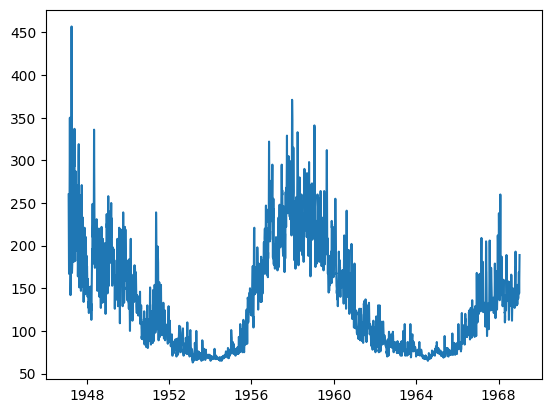

In [71]:
plt.plot(dff.head(8000)['Date'], dff.head(8000)['sfu'])

comverting the  sequnce probelem into a supervised problem 

In [2]:
import pandas as pd
df = pd.read_csv("solar_flux_data.csv")
df

,Date,sfu
0,1947-02-14,260.000000
1,1947-02-15,244.500000
2,1947-02-16,229.000000
3,1947-02-17,213.500000
4,1947-02-18,198.000000
...,...,...
26981,2020-12-28,85.983333
26982,2020-12-29,84.433333
26983,2020-12-30,83.583333
26984,2020-12-31,82.733333


In [3]:
import numpy as np
sequence = df['sfu']

def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# define input sequence
raw_seq = df['sfu']
# choose a number of time steps
n_steps = 27
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
# for i in range(len(X)):
# 	print(X[i], y[i])

In [4]:
X.shape

(26959, 27)

In [95]:
X.reshape((X.shape[0], X.shape[1], 1))

array([[[260. ],
        [234. ],
        [183. ],
        ...,
        [270. ],
        [287. ],
        [282. ]],

       [[234. ],
        [183. ],
        [167. ],
        ...,
        [287. ],
        [282. ],
        [258. ]],

       [[183. ],
        [167. ],
        [167. ],
        ...,
        [282. ],
        [258. ],
        [261. ]],

       ...,

       [[105.8],
        [110.2],
        [108.4],
        ...,
        [ 83.5],
        [ 82.8],
        [ 83.2]],

       [[110.2],
        [108.4],
        [106.3],
        ...,
        [ 82.8],
        [ 83.2],
        [ 81.9]],

       [[108.4],
        [106.3],
        [107.7],
        ...,
        [ 83.2],
        [ 81.9],
        [ 81.2]]])

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
X_train

array([[260.        , 244.5       , 229.        , ..., 321.33333333,
        307.        , 286.        ],
       [244.5       , 229.        , 213.5       , ..., 307.        ,
        286.        , 265.        ],
       [229.        , 213.5       , 198.        , ..., 286.        ,
        265.        , 244.        ],
       ...,
       [ 76.81333333,  77.        ,  76.23333333, ...,  75.6       ,
         75.36666667,  73.93333333],
       [ 77.        ,  76.23333333,  75.56666667, ...,  75.36666667,
         73.93333333,  76.58888889],
       [ 76.23333333,  75.56666667,  75.        , ...,  73.93333333,
         76.58888889,  79.24444444]])

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [9]:
X_train_transformed

array([[ 2.32286849,  2.04329831,  1.76360804, ...,  3.44069822,
         3.18232134,  2.80299014],
       [ 2.04293636,  1.76333775,  1.48362711, ...,  3.18131446,
         2.80219823,  2.42278554],
       [ 1.76300423,  1.48337719,  1.20364617, ...,  2.80128709,
         2.42207512,  2.04258094],
       ...,
       [-0.98550786, -0.98208192, -0.99585995, ..., -1.00622522,
        -1.0104969 , -1.0364728 ],
       [-0.98213664, -0.99592944, -1.00790214, ..., -1.01044775,
        -1.03644181, -0.98839401],
       [-0.99598274, -1.00797075, -1.018138  , ..., -1.03638613,
        -0.98837333, -0.94031523]])

In [10]:
X_test_transformed

array([[-1.00802283, -1.01820587, -1.03499707, ..., -0.98832975,
        -0.94030485, -0.89223645],
       [-1.01825691, -1.03506371, -1.04101817, ..., -0.94027338,
        -0.89223637, -0.85662999],
       [-1.03511304, -1.04108437, -1.02596543, ..., -0.89221701,
        -0.85663754, -0.82102352],
       ...,
       [-0.54447931, -0.60217846, -0.65988283, ..., -0.79027316,
        -0.81832355, -0.8463705 ],
       [-0.60227175, -0.65997677, -0.71768535, ..., -0.8183228 ,
        -0.84638025, -0.86175973],
       [-0.66006419, -0.71777507, -0.77548786, ..., -0.84637244,
        -0.86176619, -0.87714896]])

do not use this code

In [91]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=1)
x_input = np.array([[260, 234, 183, 167, 167]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)




Epoch 1/200
1392/1392 [==============================] - 6s 3ms/step - loss: 280.5691
Epoch 2/200
1392/1392 [==============================] - 4s 3ms/step - loss: 141.9156
Epoch 3/200
1392/1392 [==============================] - 5s 3ms/step - loss: 147.9006
Epoch 4/200
1392/1392 [==============================] - 4s 3ms/step - loss: 137.4576
Epoch 5/200
1392/1392 [==============================] - 4s 3ms/step - loss: 140.3911
Epoch 6/200
1392/1392 [==============================] - 4s 3ms/step - loss: 138.8214
Epoch 7/200
1392/1392 [==============================] - 4s 3ms/step - loss: 133.5044
Epoch 8/200
1392/1392 [==============================] - 4s 3ms/step - loss: 135.7843
Epoch 9/200
1392/1392 [==============================] - 4s 3ms/step - loss: 137.6652
Epoch 10/200
1392/1392 [==============================] - 4s 3ms/step - loss: 136.7070
Epoch 11/200
1392/1392 [==============================] - 5s 4ms/step - loss: 135.7506
Epoch 12/200
1392/1392 [============================

KeyboardInterrupt: 

In [96]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.optimizers import Adam

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# Define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# Compile model with learning rate of 0.001
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Fit model
model.fit(X, y, epochs=200, verbose=1, validation_data=(X_val,y_val))

x_input = np.array([[260, 234, 183, 167, 167]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)


Epoch 1/200
1389/1389 [==============================] - 41s 29ms/step - loss: 1448813.2500
Epoch 2/200
1389/1389 [==============================] - 40s 29ms/step - loss: 9967.7881
Epoch 3/200
1389/1389 [==============================] - 40s 29ms/step - loss: 6165.6123
Epoch 4/200
1389/1389 [==============================] - 40s 29ms/step - loss: 2656.6973
Epoch 5/200
1389/1389 [==============================] - 40s 29ms/step - loss: 887.6937
Epoch 6/200
1389/1389 [==============================] - 40s 29ms/step - loss: 524.8104
Epoch 7/200
1389/1389 [==============================] - 40s 29ms/step - loss: 491.0569
Epoch 8/200
1389/1389 [==============================] - 40s 29ms/step - loss: 493.2716
Epoch 9/200
1389/1389 [==============================] - 40s 29ms/step - loss: 437.6551
Epoch 10/200
1389/1389 [==============================] - 40s 29ms/step - loss: 415.7155
Epoch 11/200
1389/1389 [==============================] - 40s 29ms/step - loss: 411.0741
Epoch 12/200
1389/1389 

KeyboardInterrupt: 

In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# Define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# Compile model with learning rate of 0.001
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Define checkpoint callback
checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

# Fit model with checkpointing
model.fit(X, y, epochs=50, verbose=1, validation_data=(X_test, y_test), callbacks=[checkpoint])

x_input = np.array([[260, 234, 183, 167, 167]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)


c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
843/843 [==============================] - 11s 11ms/step - loss: 7004.9092 - val_loss: 311.1407
Epoch 2/50
843/843 [==============================] - 14s 16ms/step - loss: 894.1133 - val_loss: 538.8221
Epoch 3/50
843/843 [==============================] - 10s 11ms/step - loss: 815.0357 - val_loss: 818.6918
Epoch 4/50
843/843 [==============================] - 9s 11ms/step - loss: 486.8883 - val_loss: 78.1047
Epoch 5/50
843/843 [==============================] - 9s 11ms/step - loss: 449.6960 - val_loss: 88.2731
Epoch 6/50
843/843 [==============================] - 8s 10ms/step - loss: 295.0945 - val_loss: 47.1991
Epoch 7/50
843/843 [==============================] - 8s 10ms/step - loss: 185.1247 - val_loss: 50.3565
Epoch 8/50
843/843 [==============================] - 8s 10ms/step - loss: 158.2538 - val_loss: 49.3581
Epoch 9/50
843/843 [==============================] - 8s 10ms/step - loss: 144.2124 - val_loss: 38.2575
Epoch 10/50
843/843 [==============================] - 8s

ValueError: cannot reshape array of size 5 into shape (1,27,1)

In [136]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

n_features = 1
n_steps = 27

# Define model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Load the model weights from checkpoints
model.load_weights('model_weights.h5')

# Use the loaded model for prediction
x_input = X_val[1:10]
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)


c:\Users\Swaroop\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[[84.0643]]


In [37]:
len(y_test)

5392

In [ ]:
df['']

In [38]:
number_of_dates = 5000


dates = [df['Date'][i]  for  i in range(number_of_dates)]
observed = [y_test[i] for i in range(number_of_dates)]
predicted = [] 
for i in range(number_of_dates):
    
    x_input = X_test[i]
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    # print(yhat, y_test[i])
    predicted.append(yhat[0][0])    
    

#  time  shifting the dates
predited_time_shifted = [predicted[i+1] for i in range(number_of_dates-1)]
observed_time_shifted = observed[:number_of_dates-1]

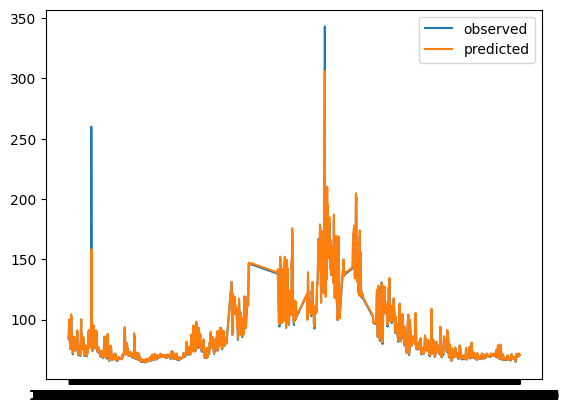

In [39]:
import matplotlib.pyplot as plt
plt.plot(dates[:number_of_dates-1], observed_time_shifted, label = "observed")
plt.plot(dates[:number_of_dates-1], predited_time_shifted, label = "predicted")
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import mean_squared_error
import numpy as np

np.sqrt(mean_squared_error(observed_time_shifted, predited_time_shifted))


2.4180209938441357

In [138]:
y_val[1]

85.83333333333333

In [150]:
df.loc[[100],['Date']]
df['Date'][100]

'1947-05-25'

In [178]:
for i in range(1000):
    dates = [df['Date'][i] for i in range(100)]
    sfu  = [df['sfu'][i] for i in range(100)]
    predicted = []
    for i in range(100):
        x_input = X_train[i]
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        predicted.append(yhat[0][0])
        
        
    # plt.plot(dates, sfu)
    # plt.plot(dates, predicted)

KeyboardInterrupt: 

In [189]:
dates = [df['Date'][i] for i in range(1000)]
sfu  = [df['sfu'][i] for i in range(1000)]

In [ ]:
for i in len(sfu):
    print(sfu[i], predicted[i])

In [ ]:
plt.plot(dates, sfu)

In [179]:
predicted = []
for i in range(1000):
        x_input = X_train[i]
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        predicted.append(yhat)

In [190]:
forecast = [predicted[i][0][0]for i in range(1000)]

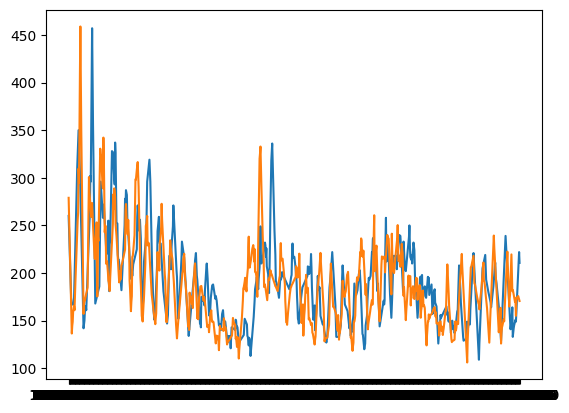

In [193]:
plt.plot(dates, sfu)
plt.plot(dates, forecast)

In [192]:
sfu

[260.0,
 244.5,
 229.0,
 213.5,
 198.0,
 182.5,
 167.0,
 167.0,
 167.0,
 167.0,
 167.0,
 170.5,
 174.0,
 193.57142857142856,
 213.14285714285717,
 232.7142857142857,
 252.28571428571428,
 271.85714285714283,
 291.42857142857144,
 311.0,
 324.0,
 337.0,
 350.0,
 335.6666666666667,
 321.3333333333333,
 307.0,
 286.0,
 265.0,
 244.0,
 223.0,
 202.0,
 181.0,
 158.0,
 142.0,
 146.0,
 150.0,
 160.0,
 162.5,
 165.0,
 161.0,
 174.0,
 187.0,
 200.0,
 213.0,
 226.0,
 239.0,
 252.0,
 261.0,
 302.0,
 296.0,
 347.0,
 402.0,
 457.0,
 406.5,
 356.0,
 318.4,
 280.8,
 243.2,
 205.6,
 168.0,
 170.0,
 172.0,
 174.0,
 176.0,
 178.0,
 180.0,
 182.0,
 184.0,
 186.0,
 222.66666666666669,
 259.33333333333337,
 296.0,
 288.4,
 280.8,
 273.2,
 265.6,
 258.0,
 265.0,
 272.0,
 262.75,
 253.5,
 244.25,
 235.0,
 226.0,
 220.0,
 228.75,
 237.5,
 246.25,
 255.0,
 191.0,
 181.0,
 230.0,
 234.0,
 257.5,
 281.0,
 304.5,
 328.0,
 327.5,
 327.0,
 317.6666666666667,
 308.3333333333333,
 299.0,
 293.0,
 337.0,
 326.0,
 289.

In [184]:
dates

['1947-02-14',
 '1947-02-15',
 '1947-02-16',
 '1947-02-17',
 '1947-02-18',
 '1947-02-19',
 '1947-02-20',
 '1947-02-21',
 '1947-02-22',
 '1947-02-23',
 '1947-02-24',
 '1947-02-25',
 '1947-02-26',
 '1947-02-27',
 '1947-02-28',
 '1947-03-01',
 '1947-03-02',
 '1947-03-03',
 '1947-03-04',
 '1947-03-05',
 '1947-03-06',
 '1947-03-07',
 '1947-03-08',
 '1947-03-09',
 '1947-03-10',
 '1947-03-11',
 '1947-03-12',
 '1947-03-13',
 '1947-03-14',
 '1947-03-15',
 '1947-03-16',
 '1947-03-17',
 '1947-03-18',
 '1947-03-19',
 '1947-03-20',
 '1947-03-21',
 '1947-03-22',
 '1947-03-23',
 '1947-03-24',
 '1947-03-25',
 '1947-03-26',
 '1947-03-27',
 '1947-03-28',
 '1947-03-29',
 '1947-03-30',
 '1947-03-31',
 '1947-04-01',
 '1947-04-02',
 '1947-04-03',
 '1947-04-04',
 '1947-04-05',
 '1947-04-06',
 '1947-04-07',
 '1947-04-08',
 '1947-04-09',
 '1947-04-10',
 '1947-04-11',
 '1947-04-12',
 '1947-04-13',
 '1947-04-14',
 '1947-04-15',
 '1947-04-16',
 '1947-04-17',
 '1947-04-18',
 '1947-04-19',
 '1947-04-20',
 '1947-04-

In [183]:
sfu

[260.0,
 244.5,
 229.0,
 213.5,
 198.0,
 182.5,
 167.0,
 167.0,
 167.0,
 167.0,
 167.0,
 170.5,
 174.0,
 193.57142857142856,
 213.14285714285717,
 232.7142857142857,
 252.28571428571428,
 271.85714285714283,
 291.42857142857144,
 311.0,
 324.0,
 337.0,
 350.0,
 335.6666666666667,
 321.3333333333333,
 307.0,
 286.0,
 265.0,
 244.0,
 223.0,
 202.0,
 181.0,
 158.0,
 142.0,
 146.0,
 150.0,
 160.0,
 162.5,
 165.0,
 161.0,
 174.0,
 187.0,
 200.0,
 213.0,
 226.0,
 239.0,
 252.0,
 261.0,
 302.0,
 296.0,
 347.0,
 402.0,
 457.0,
 406.5,
 356.0,
 318.4,
 280.8,
 243.2,
 205.6,
 168.0,
 170.0,
 172.0,
 174.0,
 176.0,
 178.0,
 180.0,
 182.0,
 184.0,
 186.0,
 222.66666666666669,
 259.33333333333337,
 296.0,
 288.4,
 280.8,
 273.2,
 265.6,
 258.0,
 265.0,
 272.0,
 262.75,
 253.5,
 244.25,
 235.0,
 226.0,
 220.0,
 228.75,
 237.5,
 246.25,
 255.0,
 191.0,
 181.0,
 230.0,
 234.0,
 257.5,
 281.0,
 304.5,
 328.0,
 327.5,
 327.0,
 317.6666666666667]

In [134]:
X_val[1].reshape((1, n_steps, n_features))

ValueError: cannot reshape array of size 27 into shape (1,5,1)

In [104]:
X_train.shape

(35534, 100, 1)

In [43]:
from sklearn.metrics import r2_score

# Assuming you have the true labels y_true and predicted labels y_pred
r2 = r2_score(observed_time_shifted, predited_time_shifted)
r2

0.9929655450395167

In [44]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(observed_time_shifted, predited_time_shifted)

0.8938704718491736

stacked 